# 2023 유행어

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('../data_inword/2023년 유행어.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20231222,"여러분 안녕하세요. 그린랜드입니다 ^^ 오늘은 2023년을 마무리하며, 올한해 일본...","신조어, 유행어를 통해 올해 일어난 사건들도 돌아볼 수 있지요ㅎ 그럼 2023년 일...",2023년 일본 신조어/유행어 TOP 10 (+후보 리스트)
1,20230414,하잉 :) 화창한 날씨에 한껏 기분 좋았는데 미먼(미세먼지) 머선129? ㅋㅋㅋ 오...,2023년 밈 유행어 모음 요즘 밈과 유행어 얼마나 알고 계시는지 체크하면서 봐주세...,2023년 밈 & 유행어 모음
2,20231205,매년 일본 언론지에서 만드는 올해 인터넷 유행어 랭킹 순위별로 몇개만 설명해보자면 ...,인방으로 버튜버나 스트리머들이 하면서 인기를 탄 게임 10위 「데스머핀」 한 이벤트...,2023년 일본 유행어 랭킹
3,20230114,"아내의 맛 나경원, 멋짐 뿜뿜! 누군 판사 안 해봤어? 21년도 하반기에 TV조선 ...","아내의 맛 연출 정희성, 신명선, 김준, 손슬지, 김채경, 백지수, 지소미 출연 이...","누군 판사 안 해봤어? 화요예능 아내의 맛 나경원, 2023년 유행어로 누군 당대표..."
4,20231208,안녕하세요. 벌써 2023년의 끝자락이 보이기 시작했습니다. 올해도 시간이 후딱 지...,"많은 추억이 담긴 <b>2023년<\/b>, 이대로 보내긴 아쉽죠? 1년 동안 우리...",2023년 유행어/밈/신조어 싹 모음! 올해 MZ들은 무슨 용어를 많이 썼나~?


## 1. 전처리

In [3]:
## 사용자 정의 단어 추가 
kiwi = Kiwi()

new = ['연진', '연진아', '박연진', '신나', '나되게신나', '스튜어디스', '혜정', '스튜어디스혜정아', '멋지다', '브라보', 
       '더글로리', '가보자고', '너T야', 'T', '뉴진스', '하입보이', '하입보이요', '홍대', 
       '농협은행', '말아주다', 'Iam신뢰예요', 'iam신뢰', '신뢰', '동료', '도도도', '도도독' '아이시떼루', '맑눈광', '빵빵아', '옥지얌', 
       '홍박사', '이유', '만남', '축복', '홍대입구', '맑.눈.광', 
       '꾸웨액', '폼미쳤다', '폼', '미쳤다', '제당슈만', '라고할뻔', '겠냐', 'ㄱㅂㅈㄱ', '이생망', 
       '너뭐돼', '모에모에뀽', 'KIJUL', 'kikul', '오히려', '엄마', '억텐', '내또출', '중꺽마' ]
## 엄마: 우리 엄마 엄마가

for i in new:
    kiwi.add_user_word(i,'NNP')

In [4]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [5]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['사람', '대하', '시작', '일본', '사용', '한국', '사랑', '때문', '중국', '사진', 
                        '미국', '사회', '영상', '단어', '표현', '블로그', '정도', '인기', '배우', '모습', 
                        '이야기', '활동', '세대', '부모', '출처', '세계', '마음', '친구', '가지', '유행', 
                        '행복', '작품', '출연', '이후', '상황', '다양', '관련', '최고', '멤버', '제공', 
                        '가능', '게임', '대상', '처음', '일상', '요즘', '보이', '여행', '진행', '프로그램', 
                        '시대', '소개', '성공', '느낌', '정보', '콘텐츠', '오늘', '생활', '내용', '기업', 
                        '투자', '경제', '대표', '캐릭터', '시장', '트렌드', '이름', '부분', '필요',  '생일',
                        '가족', '기억', '이유', '인터넷', '경우', '성장', '세상', '관심', '당시', '공부', 
                        '감사', '마지막', '대화', '시즌', '등장', '기록', '사이', '준비', '인하', '영어', 
                        '공개', '개인', '나라', '중요', '자리', '회사', '여자', '서울', '기준', '운동', 
                        '변화', '소비', '제품', '경험', '가격', '감독', '추천', '기술', '국내', '학교', 
                        '하루', '유명', '건강', '카페', '방법', '활용', '정리', '작년', '소리', '남자', 
                        '인생', '서비스', '정부', '시절', '노력', '하나님', '예수', '그룹', '브랜드', '일본어', 
                        '이해', '언니', '결과', '미래', '이용', '기대', '선택', '현실', '평가', '사건', 
                        '아이돌', '설명', '지역', '참여', '과정', '확인', '공간', '고민', '인간', '지원', 
                        '아빠', '커피', '목표', '사실', '기분', '의미', '환경', '자체', '상태', '방식', 
                        '말씀', '음식', '능력', '블로그', '기간', '선정', '선물', '국가', '순간', '영향', 
                        '행동', '관계', '뉴스', '아침', '도움', '가치', '관리', '분위기', '개발', '얘기', 
                        '저녁', '소비자', '선수', '모델', '인상', '포함', '발견', '예상', '지속', '정신', 
                        '경기', '올해', '생각', '유행어', '방송', '신조어', '라이브', '역사', '지금', '데뷔',
                        '수업', '계획', '도전', '용어', '데이터', '작가', '마무리', '연기', '나이', '교육',
                        '본인', '얼굴', '구매', '코로나', '감정', '전화', '발표', '존재', '분야', '선생', 
                        '미디어', '이미지', '시험', '재미', '에너지', '공연', '오랜만', '기회', '버전', '인물', 
                        '기사', '방문', '무대', '장면', '상승', '주인공', '사업', '대한민국', '운영', '질문', 
                        '예정', '행사', '스타', '시리즈', '증가', '거리', '광고', '상품', '해외', '공식', '버스', 
                        '언어', '주목', '여성', '도착', '과거', '머리', '대학', '발생', '결정', '연말', '주문', 
                        '부산', '매력', '개월', '패션', '아버지', '음악', '주식', '예술', '어머니', '취향', '내년',
                        '수준', '스타일', '정책', '현상', '구성', '유지', '공감', '금리', '덕분', '채널', '점심', 
                        '판매', '결혼', '역할', '일반', '상대', '바다', '센터', '아래', '중심', '마케팅', '최근', 
                        '디지털', '실패', '추가', '주변', '그림', '부동산', '콘서트', '플레이', '조사', '조현병', 
                        '산업', '분석', '중간', '해당', '공유', '연습', '일정', '플랫폼', '생기', '프로젝트', '효과', 
                        '블루', '보호', '만족', '출시', '위기', '부족', '여름', '시기', '제작', '국민', '발전', '일부', 
                        '전문', '소식', '사이트', '검색', '날씨', '대중', '사장', '언급', '화제', '위험', '전체', 
                        '해결', '키워드', '자녀', '주요', '기본', '남편', '특별', '동생', '추억', '교수', '고객', 
                        '금융', '전시', '예능', '구경', '대신', '전략', '프로', '달성', '기존', '댄스', '규모', '걱정', 
                        '응원', '약속', '새해', '인사', '포스팅', '디자인', '출근', '온라인', '생산', '수익', '라면',
                        '아들', '개그', '집중', '바람', '카드', '스토리', '고기'
                        ]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [6]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [7]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    # wordclass_column = 'wordclass_' + column 
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 3min 10s
Wall time: 8min 14s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20231222,여러분 안녕하세요 그린랜드입니다 오늘은 2023년을 마무리하며 올한해 일본의 신조어...,신조어 유행어를 통해 올해 일어난 사건들도 돌아볼 수 있지요ㅎ 그럼 2023년 일본...,2023년 일본 신조어유행어 TOP 10 후보 리스트,그린랜드 은 해 도 수 알 아레 아레 거 뜻 요 야구 구단 한신 타이거즈 슬로건 라...,도 수 알,후보 리스트
1,20230414,하잉 화창한 날씨에 한껏 기분 좋았는데 미먼미세먼지 머선129 ㅋㅋㅋ 오늘은 202...,2023년 밈 유행어 모음 요즘 밈과 유행어 얼마나 알고 계시는지 체크하면서 봐주세...,2023년 밈 유행어 모음,하잉 미먼 미세먼지 머선 유행 밈 밈 모음 밈 체크 보 상반기 더 글로리 다했져 더...,밈 모음 밈 체크 보 요 제당슈 슈퍼스타 줄임 뻔,밈
2,20231205,매년 일본 언론지에서 만드는 올해 인터넷 유행어 랭킹 순위별로 몇개만 설명해보자면 ...,인방으로 버튜버나 스트리머들이 하면서 인기를 탄 게임 10위 데스머핀 한 이벤트에서...,2023년 일본 유행어 랭킹,언론 지 랭킹 순위 개 위 증세안 경 총리 인 기시다 후미오 별명 역대 최저 지지율...,인방 버튜버 스트리머 위 데스머핀 이벤트 머핀 단체 되 랭킹,랭킹
3,20230114,아내의 맛 나경원 멋짐 뿜뿜 누군 판사 안 해봤어 21년도 하반기에 TV조선 화요일...,아내의 맛 연출 정희성 신명선 김준 손슬지 김채경 백지수 지소미 출연 이휘재 박명수...,누군 판사 안 해봤어 화요예능 아내의 맛 나경원 2023년 유행어로 누군 당대표 안...,아내 맛 나경원 판사 년도 하반기 조선 화요일 아내 맛 나경원 의원 아내 맛 출발 ...,아내 맛 연출 정희성 신명 김준 손슬지 김 채경 백지수 지소미 이휘재 박명수 장영란...,판사 화요 아내 맛 나경원 당
4,20231208,안녕하세요 벌써 2023년의 끝자락이 보이기 시작했습니다 올해도 시간이 후딱 지나간...,많은 추억이 담긴 b2023년b 이대로 보내긴 아쉽죠 1년 동안 우리에게 웃음을 선...,2023년 유행어밈신조어 싹 모음 올해 MZ들은 무슨 용어를 많이 썼나,끝 자락 도 데 담 웃음 선사 주 밈 번 은 개 체크 보 신 말 초 전 드라마 더 ...,웃음 선사 주 밈 번 은 개 체크,밈


In [8]:
# 전처리한 결과 csv로 저장 
df.to_csv('23유행어_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [9]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts


### [preprocessed_body]

In [10]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [11]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
21425,영화,1155
7479,드라마,843
20479,엄마,671
10865,문제,595
5210,노래,564
10900,문화,514
23630,유튜브,448
29582,최애,304
6095,달러,258
5170,넷플릭스,254


In [12]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['영화',
 '드라마',
 '엄마',
 '문제',
 '노래',
 '문화',
 '유튜브',
 '최애',
 '달러',
 '넷플릭스',
 '연애',
 '오빠',
 '최대',
 '요리',
 '진심',
 '케이크',
 '업무',
 '이동',
 '하늘',
 '특징',
 '도파민',
 '직원',
 '주제',
 '감동',
 '메뉴',
 '시스템',
 '연구',
 '근처',
 '퇴근',
 '입장']

In [13]:
## 한 번 해본 것

for i in all_words_body['word']:
    if i in new:
        count = all_words_body.loc[all_words_body['word'] == i, 'count'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '엄마' is: 671
The count for '신뢰' is: 101
The count for '동료' is: 91
The count for '만남' is: 86
The count for '축복' is: 69
The count for '연진' is: 69
The count for '홍대' is: 62
The count for '뉴진스' is: 57
The count for '농협은행' is: 42
The count for '혜정' is: 14
The count for '중꺽마' is: 7
The count for '겠냐' is: 6
The count for '꾸웨액' is: 6
The count for '브라보' is: 6
The count for '모에모에뀽' is: 5
The count for '신나' is: 5
The count for '맑눈광' is: 5
The count for '너뭐돼' is: 5
The count for '억텐' is: 4
The count for '이유' is: 2
The count for '옥지얌' is: 2
The count for '스튜어디스' is: 2
The count for '하입보이' is: 1
The count for '하입보이요' is: 1


### [preprocessed_description]

In [14]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
80,결산,40
1439,일기,26
2076,후기,25
1224,영화,22
633,문화,18
444,드라마,18
1590,중국어,18
864,상반기,14
307,넷플릭스,13
1545,제목,13


### [preprocessed_title]

In [15]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_word_counts = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_word_counts = all_word_counts[all_word_counts['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_word_counts.head(30)
top_30_words

,word,count
968,드라마,51
2679,영화,33
2481,애창곡,29
2542,엄마,25
1379,문화,23
686,노래,22
3956,탄생,22
461,글로리,22
3466,중국어,21
678,넷플릭스,20


# 3. TF-IDF

In [16]:
# ## 참고 사이트
# ## -> https://foreverhappiness.tistory.com/30
# ## -> https://foreverhappiness.tistory.com/35
# ## -> https://foreverhappiness.tistory.com/37
# ## 너무 오래 걸려서 안 돌림


# import pandas as pd
# from tqdm import tqdm
# from konlpy.tag import Okt
# from sklearn.feature_extraction.text import CountVectorizer

# # DTM (Document-Term Matrix) creation using Scikit-Learn's CountVectorizer
# # DTM(Document-Term Matrix) 생성 함수
# def NLP_DTM(df):
#     # 타이틀 리스트를 데이터프레임의 'preprocessed_title' 열에서 가져옴
#     title_lst = df['preprocessed_title']
    
#     # 불용어 리스트를 정의
#     stop_words_list = ['사람', '대하']
    
#     # Okt 형태소 분석기를 초기화
#     tagger = Okt()

#     # 결과를 저장할 DataFrame 초기화
#     result_df = pd.DataFrame()

#     # 타이틀 리스트를 순회하며 진행도를 표시
#     for title in tqdm(title_lst, desc='타이틀 리스트 진행도'):
#         # CountVectorizer 객체를 초기화
#         cv = CountVectorizer()

#         # 각 문서의 말뭉치를 저장할 리스트를 초기화
#         corpus = []

#         # 문서 진행도를 표시하며 타이틀 리스트의 각 요소에 대해 반복
#         for i in tqdm(range(len(df['preprocessed_body'])), desc='문서 진행도'):
#             # 각 타이틀에 대해 명사 리스트를 생성합니다.
#             n_lst = tagger.nouns(df['preprocessed_body'].iloc[i])
#             corpus.append(' '.join(n_lst))

#         # 말뭉치 데이터를 사용해 DTM(Document-Term Matrix)을 생성
#         DTM_array = cv.fit_transform(corpus).toarray()
        
#         # DTM의 각 열이 어떤 단어에 해당하는지 feature_names에 저장
#         feature_names = cv.get_feature_names_out()

#         # DTM 배열을 DataFrame 형식으로 변환
#         DTM_df = pd.DataFrame(DTM_array, columns=feature_names)
        
#         # 불용어 리스트에 있는 단어들을 DTM DataFrame에서 제거
#         DTM_df.drop(columns=stop_words_list, inplace=True, errors='ignore')
        
#         # 결과 DataFrame에 현재 DTM DataFrame을 추가
#         result_df = pd.concat([result_df, DTM_df], axis=0)

#     return result_df


# # %%time
# dtm_df = NLP_DTM(df)
# dtm_df

## 교수님 코드

In [17]:
## DTM (Document Term Matrix)
## 이거 안 하고 바로 TF-IDF로 가도 됨

import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer


documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
results = vector.fit_transform(documents).toarray()

results

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [8, 7, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
## TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

documents = df['preprocessed_body']
word_dict = all_word_counts['word']
vector = CountVectorizer(vocabulary=word_dict)
dtm = vector.fit_transform(documents).toarray()


vector = TfidfVectorizer(vocabulary=word_dict)
tfidf = vector.fit_transform(documents).toarray()

tfidf

array([[0.03935643, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07928759, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09268355, 0.07913328, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 가정: df는 미리 전처리된 텍스트 데이터 프레임
documents = df['preprocessed_body']
word_dict = all_word_counts['word'].tolist()

# TF-IDF 계산
vectorizer = TfidfVectorizer(vocabulary=word_dict)
tfidf_matrix = vectorizer.fit_transform(documents).toarray()

# 각 단어의 TF-IDF 값을 집계
tfidf_scores = tfidf_matrix.sum(axis=0)
words = vectorizer.get_feature_names_out()

# 데이터 프레임 생성
tfidf_df = pd.DataFrame({'words': words, 'counts': tfidf_scores})

# TF-IDF 값이 큰 순서로 정렬
tfidf_df = tfidf_df.sort_values(by='counts', ascending=False).reset_index(drop=True)


tfidf_df

,words,counts
0,영화,24.754675
1,드라마,21.640110
2,엄마,20.399325
3,노래,17.147112
4,최애,15.077031
...,...,...
4126,총모음그닺채중꺽마,0.000000
4127,바로가기,0.000000
4128,마지막날,0.000000
4129,마크로,0.000000


In [20]:
## 한 번 해본 것

for i in tfidf_df['words']:
    if i in new:
        count = tfidf_df.loc[tfidf_df['words'] == i, 'counts'].values[0]
        print(f"The count for '{i}' is: {count}")

The count for '엄마' is: 20.399324534242
The count for '연진' is: 4.61485312114863
The count for '동료' is: 4.1804281009816044
The count for '신뢰' is: 3.945315167492402
The count for '농협은행' is: 3.7517489856334785
The count for '만남' is: 3.543256516413835
The count for '홍대' is: 3.5233561291160402
The count for '뉴진스' is: 3.496885662413355
The count for '혜정' is: 0.9609324749416549
The count for '중꺽마' is: 0.8714151115917308
The count for '겠냐' is: 0.8338401369405043
The count for '이유' is: 0.2928793032685091


# 4. 워드 클라우드

## 필요한 모듈 임포트

In [21]:
from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline

import konlpy

## WordCloud 클래스의 객체 생성

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [22]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [23]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'영화': 1155,
 '드라마': 843,
 '엄마': 671,
 '문제': 595,
 '노래': 564,
 '문화': 514,
 '유튜브': 448,
 '최애': 304,
 '달러': 258,
 '넷플릭스': 254,
 '연애': 193,
 '오빠': 192,
 '최대': 173,
 '요리': 173,
 '진심': 173,
 '케이크': 172,
 '업무': 172,
 '이동': 172,
 '하늘': 172,
 '특징': 172,
 '도파민': 172,
 '직원': 172,
 '주제': 172,
 '감동': 172,
 '메뉴': 172,
 '시스템': 171,
 '연구': 171,
 '근처': 170,
 '퇴근': 169,
 '입장': 169,
 '촬영': 168,
 '개념': 168,
 '자연': 168,
 '특정': 167,
 '맥주': 167,
 '개그맨': 167,
 '동시': 167,
 '글로리': 167,
 '작업': 167,
 '비용': 166,
 '차이': 166,
 '인정': 166,
 '중국어': 165,
 '장소': 164,
 '학생': 164,
 '반응': 164,
 '나름': 163,
 '대통령': 163,
 '이슈': 163,
 '이랑': 162,
 '자동차': 161,
 '년대': 160,
 '동네': 160,
 '도시': 160,
 '소재': 160,
 '요소': 160,
 '애니메이션': 160,
 '파티': 158,
 '대사': 157,
 '불안': 157,
 '이전': 157,
 '딸기': 157,
 '세븐': 157,
 '스트레스': 157,
 '예전': 157,
 '만화': 156,
 '시청': 155,
 '이제': 155,
 '자유': 155,
 '연출': 155,
 '목소리': 154,
 '기능': 154,
 '웃음': 154,
 '기관': 153,
 '전쟁': 153,
 '위치': 153,
 '인천': 153,
 '비교': 153,
 '예약': 152,
 '식사': 152,
 '사고': 151,
 '우승': 15

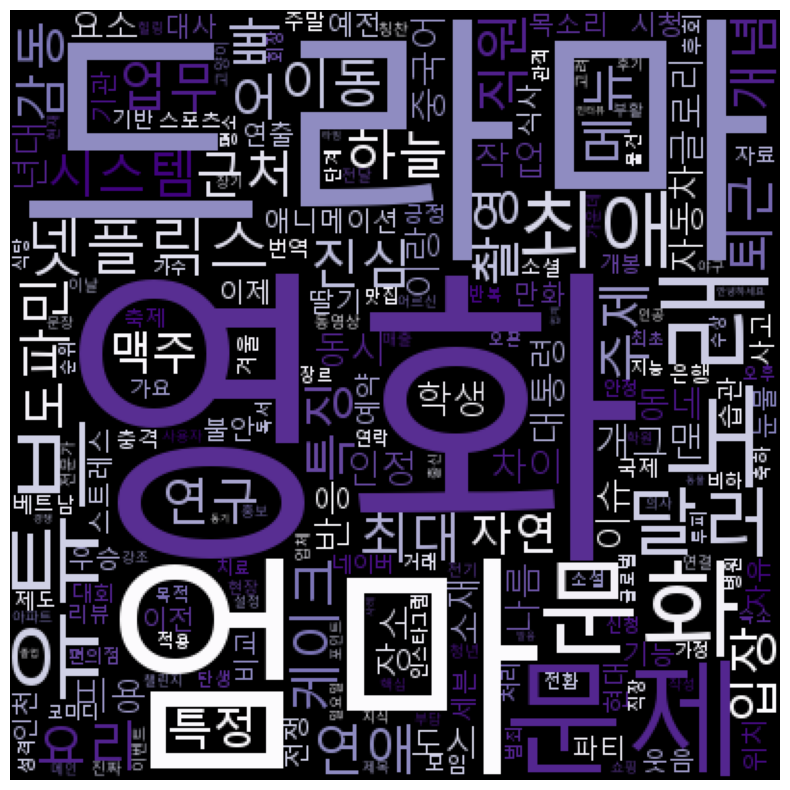

In [24]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Purples')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기